##Importing the necessary packages


In [1]:
import numpy as np
import pandas as pd
import time
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LeakyReLU, Dense, Bidirectional, Activation, Flatten, Dropout
from keras.layers import Conv2DTranspose, Conv2D, LSTM, BatchNormalization, MaxPooling2D, Reshape
from keras.utils import to_categorical
from keras.regularizers import L1L2
from keras.initializers import lecun_uniform
from keras.optimizers import Adam
from keras.metrics import categorical_accuracy
import matplotlib.pyplot as plt
from keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd "/content/drive/MyDrive/ECE247-Project"
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

/content/drive/.shortcut-targets-by-id/1ELPC9CkLUbTPdE0JP9VLaPzrtY2b7Uf_/ECE247-Project


In [4]:
# setup tensorflow + TPU 
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.11.0
Running on TPU  ['10.85.234.250:8470']


##Loading and visualizing the dataset 

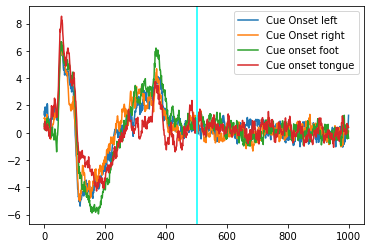

In [5]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [6]:
#Numpy and Keras Random Seed Assignment
np.random.seed(1)
k_initializer = lecun_uniform(seed=42)

In [7]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


##Preparing the training, validation, and test datasets

In [8]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)



# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (15

#(GAN-CNN)

##(GAN-CNN) Creating the discriminator and generator


(6960, 250, 22)
(6960, 4)
132 26


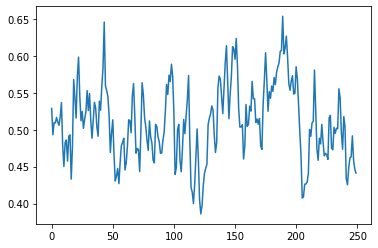

In [9]:
batch_size = 128
num_channels = 22
num_classes = 4
latent_dim = 128
x_train_gan = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[3])
x_valid_gan = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[3])
x_test_gan = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[3])
max_train = np.max(np.absolute(x_train_gan))
all_digits = x_train_gan/(2*max_train) + 0.5
plt.plot(all_digits[0,:,0])
all_labels = y_train
all_digits = all_digits.astype("float32")
print(all_digits.shape)
print(all_labels.shape)
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=256).batch(batch_size)
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)


generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(10 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((10 , generator_in_channels)),
        layers.Conv1DTranspose(128, (11,), strides=(5,), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv1DTranspose(128, (11,), strides=(5,), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv1D(22, (10,), padding="same", activation="sigmoid"),
    ],
    name="generator",
)



discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((250, discriminator_in_channels)),
        layers.Conv1D(64, (9,), strides=(5,), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv1D(128, (9,), strides=(5,), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling1D(),
        layers.Dense(1),
    ],
    name="discriminator",
)


##(GAN-CNN) Creating a ConditionalGAN model

In [10]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:,:, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[250]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, 250, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

##(GAN-CNN) Training the Conditional GAN

In [11]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=20)

Epoch 1/20
55/55 [==============================] - 5s 47ms/step - g_loss: 0.6846 - d_loss: 0.7106
Epoch 2/20
55/55 [==============================] - 3s 47ms/step - g_loss: 0.6627 - d_loss: 0.8594
Epoch 3/20
55/55 [==============================] - 3s 47ms/step - g_loss: 1.0710 - d_loss: 0.7579
Epoch 4/20
55/55 [==============================] - 3s 47ms/step - g_loss: 1.3691 - d_loss: 0.7014
Epoch 5/20
55/55 [==============================] - 3s 46ms/step - g_loss: 3.5407 - d_loss: 0.0867
Epoch 6/20
55/55 [==============================] - 3s 47ms/step - g_loss: 2.2517 - d_loss: 0.4442
Epoch 7/20
55/55 [==============================] - 3s 47ms/step - g_loss: 1.7744 - d_loss: 0.4477
Epoch 8/20
55/55 [==============================] - 3s 47ms/step - g_loss: 0.6776 - d_loss: 1.0799
Epoch 9/20
55/55 [==============================] - 3s 48ms/step - g_loss: 1.0759 - d_loss: 1.5412
Epoch 10/20
55/55 [==============================] - 3s 47ms/step - g_loss: 3.5234 - d_loss: 0.2030
Epoch 11/

##(GAN-CNN) Interpolating between classes with the trained generator

In [12]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 10  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )
    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake, interpolation_labels


fake_real_data = all_digits
fake_real_labels = all_labels
print(fake_real_data.shape)
for start_class in range(4):
  for end_class in range(4):
    fake_images,fake_labels = interpolate_class(start_class, end_class)
    print(fake_images.shape)
    fake_real_data = np.concatenate((fake_real_data,fake_images),axis=0)
    fake_real_labels = np.concatenate((fake_real_labels,fake_labels),axis=0)

fake_real_data = fake_real_data.reshape(fake_real_data.shape[0],fake_real_data.shape[1], fake_real_data.shape[2], 1)
# plt.plot(fake_images[0,:,0])
fake_real_data = np.swapaxes(fake_real_data, 2,3)

print(fake_real_data.shape)

x_train = (fake_real_data - 0.5)*2*max_train
y_train = fake_real_labels




(6960, 250, 22)
1/1 [==============================] - 0s 189ms/step
(10, 250, 22)
1/1 [==============================] - 0s 33ms/step
(10, 250, 22)
1/1 [==============================] - 0s 64ms/step
(10, 250, 22)
1/1 [==============================] - 0s 33ms/step
(10, 250, 22)
1/1 [==============================] - 0s 34ms/step
(10, 250, 22)
1/1 [==============================] - 0s 32ms/step
(10, 250, 22)
1/1 [==============================] - 0s 34ms/step
(10, 250, 22)
1/1 [==============================] - 0s 33ms/step
(10, 250, 22)
1/1 [==============================] - 0s 33ms/step
(10, 250, 22)
1/1 [==============================] - 0s 31ms/step
(10, 250, 22)
1/1 [==============================] - 0s 31ms/step
(10, 250, 22)
1/1 [==============================] - 0s 34ms/step
(10, 250, 22)
1/1 [==============================] - 0s 37ms/step
(10, 250, 22)
1/1 [==============================] - 0s 33ms/step
(10, 250, 22)
1/1 [==============================] - 0s 32ms/step
(10, 25

##(GAN-CNN) Building a basic CNN model

In [13]:
def CNN(initializer, max_timeStep=500, debug_mode=False, learning_rate=1e-3):
  # Building the CNN model using sequential class
  basic_cnn_model = Sequential()

  # Conv. block 1
  basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(int(max_timeStep/2),1,22)))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) 
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))

  # Conv. block 2
  basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))

  # Conv. block 3
  basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))

  # Conv. block 4
  basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))

  # Output layer with Softmax activation
  basic_cnn_model.add(Flatten()) # Flattens the input
  basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

  # Printing the model summary
  if debug_mode:
    basic_cnn_model.summary()

  cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  # Compiling the model
  basic_cnn_model.compile(loss='categorical_crossentropy',
                  optimizer=cnn_optimizer,
                  metrics=['accuracy'])

  return basic_cnn_model

##(GAN-CNN) Compiling, training and validating the model

In [14]:
# Model parameters
n_epochs=100

# Creating and compiling the model
basic_cnn_model = CNN(k_initializer, debug_mode=True)

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(x_train,
            y_train,
            batch_size=64,
            epochs=n_epochs,
            validation_data=(x_valid, y_valid), verbose=True) 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 25)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 25)        100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 25)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 1, 50)        0

##(GAN-CNN) Visualizing the accuracy and loss trajectory

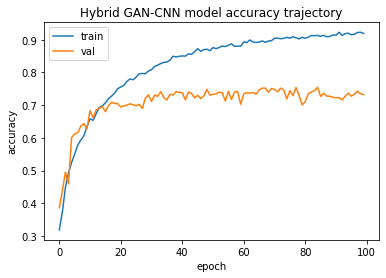

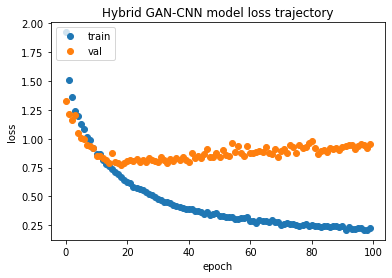

In [17]:
# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Hybrid GAN-CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Hybrid GAN-CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##(GAN-CNN) Testing the performance of the basic CNN model on the held out test set



In [18]:
## Testing the GAN-CNN model

cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the GAN-CNN model:',cnn_score[1])

Test accuracy of the GAN-CNN model: 0.6822798848152161
